In [5]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 67.5 MB/s eta 0:00:00


In [7]:
import os
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [8]:
random_seed = 42
torch.manual_seed(random_seed)
BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)
print(AVAIL_GPUS, NUM_WORKERS)

1 1


In [39]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):

        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # train and val
        if stage=="fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        # test
        if stage=="test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [11]:
# fake or no fake
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [19]:
conv10 = nn.Conv2d(1, 10, kernel_size=5)
conv20 = nn.Conv2d(10, 20, kernel_size=5)

In [23]:
x = conv10(torch.randn(1, 1, 28, 28))
x = F.max_pool2d(x, 2)
x = conv20(x)
x = F.max_pool2d(x, 2)
x.shape, x.view(-1).shape

(torch.Size([1, 20, 4, 4]), torch.Size([320]))

In [30]:
# Generate fake data, output like real data [1, 28, 28] and values [-1, 1]
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64) # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7) # [n , 1, 28, 28]

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7) #256

        # Upsample (transposed conv) 16x16 (64 feature map)
        x = self.ct1(x)
        x = F.relu(x)

        # upsample to 34x34 (16 feature map)
        x = self.ct2(x)
        x = F.relu(x)

        # convolution to 28x28 (1 feature map)
        return self.conv(x)

In [24]:
deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
deconv2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
conv = nn.Conv2d(16, 1, kernel_size=7)
conv(deconv2(deconv1(torch.randn((64, 7, 7))))).shape

torch.Size([1, 28, 28])

In [35]:
# create one class (GAN) that inherits from pytorch_lightning
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization=False

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # random_noise
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adverserial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        optimizer_g, optimizer_d = self.optimizers()

        # sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # train generator: max log(D(G(z)))
        self.toggle_optimizer(optimizer_g)
        fake_imgs = self(z)
        y_hat  = self.discriminator(fake_imgs)

        y = torch.ones(real_imgs.size(0), 1)
        y = y.type_as(real_imgs)

        g_loss = self.adverserial_loss(y_hat, y)
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)


        # train discriminator: max log(D(x)) + log(1 - D(G(z)))
        self.toggle_optimizer(optimizer_d)

        # how well can it label as real
        y_hat_real = self.discriminator(real_imgs)

        y_real = torch.ones(real_imgs.size(0), 1)
        y_real = y_real.type_as(real_imgs)

        real_loss = self.adverserial_loss(y_hat_real, y_real)

        # how well can it label as fake
        y_hat_fake = self.discriminator(self(z).detach())
        y_fake = torch.zeros(real_imgs.size(0), 1)
        y_fake = y_fake.type_as(real_imgs)

        fake_loss = self.adverserial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss)/2

        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight) #move it to gpu if it is running on
        sample_imgs = self(z).cpu()

        print('Epoch ', self.current_epoch)
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :],cmap="gray_r", interpolation='none')
            plt.title('Generated Data')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()


    # run at the end of each epoch, here we want to plot some figures
    def on_epoch_end(self):
        self.plot_imgs()


In [41]:
dm = MNISTDataModule()
model = GAN()

Epoch  0


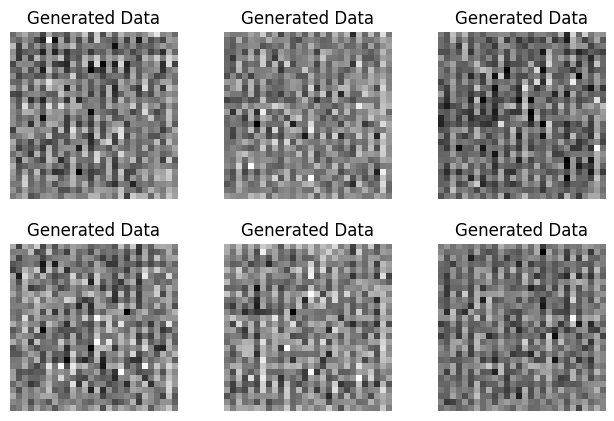

In [37]:
model.plot_imgs()

In [42]:
trainer = pl.Trainer(max_epochs=20, accelerator="auto")
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.42MB/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch  20


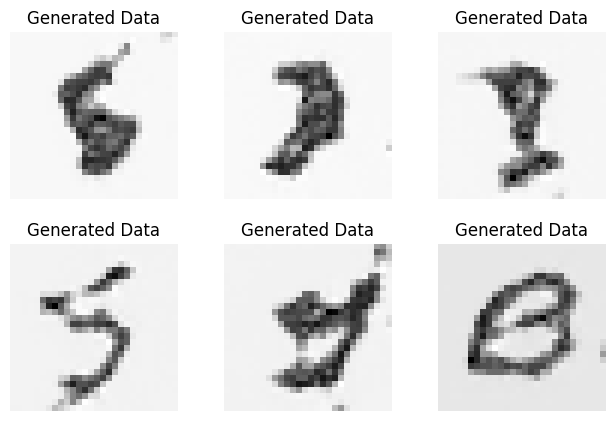

In [43]:
model.plot_imgs()